# Practical: Working with sampled audio

Eamonn Bell  
<eamonn.bell@durham.ac.uk>

By the end of this practical you should able to:

- compute the center frequencies for all MIDI numbers 0-127
- understand how alternative tuning systems ("temperaments") may come about
- synthesise simple sounds (sinusoids)
- synthesise combinations of simple sounds to produce richer sounds
- load a sound file and produce a waveform visualisation using `matplotlib` and `librosa`
- estimate the frequency of a musical sound in the time-domain
- reorder the segments in an audio file programmatically



In [1]:
import numpy as np
import librosa
import soundfile
import IPython.display as ipd

from matplotlib import pylab as plt

## Before you do anything else

Head to YouTube, pick a song you like. Listen to it at the normal volume you listen to it at. Turn down the system volume - not the player volume - so that the song is barely audible.  

## 1 Working with pitch

This is a warm-up task and a (re)introduction to thinking with NumPy. Recall from lecture the formula for computing the center frequency of a pitch given a MIDI note number: 

### 1.1 Computing center frequency given a MIDI number

Write a function `f_pitch(p)` that takes a single MIDI note number `p` and returns the center frequency of the pitch with that MIDI note number

In [ ]:
def f_pitch(p):
    """Compute center frequency for (single or array of) MIDI note numbers.

    Args:
        p: MIDI note numbers

    Returns:
        freq_center: Center frequency
    """
    # vvvvvvvvvvvvvvvvvvvvv
    freq_center = 2 ** ((p - 69) / 12) * 440
    return freq_center
    # ^^^^^^^^^^^^^^^^^^^^^

### 1.2 Computing center frequency for all valid MIDI note numbers


The MIDI format is a binary format that specifies musical events using three bytes: one status byte and two data bytes. 

The "Note On" event uses the most significant (MSB) of the two data bytes to store the MIDI note number of the note to be triggered. The MSB of each of the three bytes is set to 1 (if a status byte) or 0 (if a data byte). 

How many valid MIDI note numbers are there? What are their center frequencies? How can you use `f_pitch` to return a list of the center frequencies for all valid MIDI note numbers?

In [ ]:
def f_all_valid_midi():
    """Compute center frequency for (single or array of) MIDI note numbers.

    Returns:
        center_freqs: Center frequency
    """
    # vvvvvvvvvvvvvvvvvvvvv
    center_freqs = [f_pitch(p) for p in range(0, 128)]
    return center_freqs
    # ^^^^^^^^^^^^^^^^^^^^^

In [4]:
np.all(np.isclose(f_all_valid_midi(), f_pitch(np.arange(0, 128))))

True

### 1.3 Computing the frequencies of harmonics

If we know the center frequency of a pitch we can easily compute the frequencies that correspond to its harmonic partials. Write a function `make_h` that takes as input an array of center frequencies of length $N$, and returns an $M \times N$ array `H`, where the entry at `H[m][n]` is the center frequency of the $n$-th harmonic above MIDI note number $m$

In [ ]:
def make_h(center_frequencies, num_harmonics):
    """Compute harmonics above center frequencies given
         up to num_harmonics

    Returns:
        H (ndarray): A 2D numpy matrix as above
    """
    # vvvvvvvvvvvvvvvvvvvvv
    multipliers = np.arange(1, num_harmonics + 1)
    H = center_frequencies.reshape(-1, 1) * multipliers
    return H
    # ^^^^^^^^^^^^^^^^^^^^^

In [6]:
cf = f_pitch(np.arange(0, 128))
H = make_h(cf, 128)

In [7]:
H[69][2]

1320.0

### 1.4 Computing center frequencies of pitches related by an octave

Similarly, write a function `make_o` that takes as input an array of center frequencies of length N, and returns an MxN matrix `O`, where the entry at `O[m][n]` is the center frequency of the pitch `n` octaves above MIDI note number `m`

In [ ]:
def make_o(center_frequencies, num_octaves):
    """Compute octave-related pitches
        center frequencies given, up to num_octaves

    Returns:
        O (ndarray): A 2D numpy matrix as above
    """
    # vvvvvvvvvvvvvvvvvvvvv
    multipliers = 2 ** np.arange(0, num_octaves)
    return center_frequencies.reshape(-1, 1) * multipliers
    # ^^^^^^^^^^^^^^^^^^^^^   


In [9]:
O = make_o(cf, 8)

In [10]:
O[69][2]

1760.0

### 1.5 Relationship between 12-tone equal temperament and harmonics

We introduced the concept of scientific pitch notation (SPN) with the idea that every MIDI note number can be given (at least one) SPN identifier, which is composed of:

- a letter part, optionally with some sharps/flats, and other things (e.g. A, D, C#, D-, etc.)
- octave (represented as an integer)

By convention, MIDI note number 69 is **A4** (= 440Hz) under this system. 

One consequence is that the MIDI note number 12 steps above (81) is labeled **A5**. 

Because frequencies that are octave-related sound similar to each other, these seems to justify giving the same letter part to both labels, even though they are different pitches.

We can call the "letter part" of a SPN representation of a note that note's **pitch class**.

Let's think about the relationship between the center frequencies of all the possible MIDI note numbers and the frequencies that appear in the matrices `H` and `O`. Here are the first 10 harmonics of middle C (C3):

In [11]:
H[60][:10]

array([ 261.6255653 ,  523.2511306 ,  784.8766959 , 1046.5022612 ,
       1308.1278265 , 1569.7533918 , 1831.3789571 , 2093.0045224 ,
       2354.63008771, 2616.25565301])

In [12]:
cf[60 + 12 + 7]

783.9908719634985

Study the following function, which produces a plot that compares the center frequency of every MIDI note number to the frequency of all the harmonics of each MIDI note number. Play around with the arguments.

With its default parameters, one thing that it shows is that the frequency that generates the second harmonic of C3 (i.e. 784.876Hz) is very close to a frequency that appears in the list of MIDI note number center frequencies (MIDI note number G5, i.e. 783.99Hz). What this implies is that there appears to be some relationship between the notes that we use in everyday music, as modeled by the MIDI note numbers/piano keys (an artificial construct) and the pitches that appear in the **harmonic series**, which is a natural phenomenon.

In [13]:
def midi_harmonics(center_mnn=60, num_harmonics=16, tolerance=1e-02):
    cf = f_pitch(np.arange(0, 128))
    cax = plt.imshow(np.isclose(H[center_mnn][:num_harmonics], cf[:,None], 1e-02).T, cmap='Greys', 
                     interpolation='none', aspect='auto')
    plt.xlabel('Pitch (MIDI note number)')
    plt.ylabel('n-th Harmonic (n)')
    plt.show()

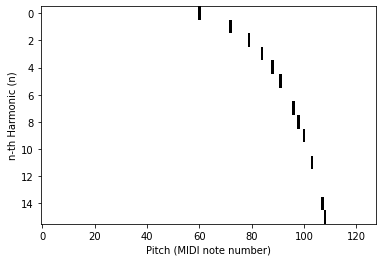

In [14]:
midi_harmonics()

In [15]:
np.where(np.isclose(H[60][:16], cf[:,None], 1e-02))

(array([ 60,  72,  79,  84,  88,  91,  96,  98, 100, 103, 107, 108]),
 array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 11, 14, 15]))

Specifically, the frequencies that generate the MIDI note numbers can be thought of as approximations of more simple mathematical relationships that would "ideally" be used, and which are related to the harmonic series. For example, consider the relation between the center frequency of C3 (= MIDI note number 60) and G4 (= MIDI note number 67). G4 is 7 equal-tempered semitones above C3;  in music theory, we call that interval a **perfect fifth**.

In [16]:
cf[60], cf[67]

(261.6255653005986, 391.99543598174927)

In [17]:
cf[60]/cf[67]

0.6674199270850172

This ratio is very close to 2/3, which appears in the harmonic series. 

Let's use this integer ratio and multiply the frequency generating the lower sound (C3) appropriately to produce a new frequency. Let's call that frequency the center frequency of the note a **pure perfect fifth** above C3.

In [18]:
cf[60] * (3/2)

392.43834795089793

Write a function `check_perfect` which takes as input a MIDI note number, and returns the difference in Hertz between the pitch an equal-tempered perfect fifth above the given note and the note a pure perfect fifth above it. 

In [ ]:
def check_perfect(mnn):
    """Difference between pure and ET intervals

    Args:
        mnn (int): MIDI note number

    Returns:
        d (scalar): Difference in Hertz between frequency
          of ET perfect fifth above and pure perfect fifth
          above given MIDI note number 

    """
    # vvvvvvvvvvvvvvvvvvvvv    
    cf = f_pitch(np.arange(0, 128))
    base = cf[mnn]
    
    etp5_above = cf[mnn + 7]
    pp5_above = base * (3/2)
    
    d = etp5_above - pp5_above
    
    return d
    # ^^^^^^^^^^^^^^^^^^^^^

In [20]:
checked = check_perfect(np.arange(60, 72))

There is one more step to perform, which will demonstrate that these frequency differences are perceptually equivalent.

## 2 Making sounds 

### 2.1 Synthesizing sine tones using trigonometric functions

Recall that we defined a simple sinusoid $g: \mathbb{R} \to \mathbb{R}$ as $g(t) := A\,\sin(2\pi(\omega t - \varphi))$

Write a function `generate_sinusoid(dur, Fs, amp, freq, phase)` that returns a NumPy array containing the values of a sampled version of this sinusoid. `Fs` is the sample rate.

It may be counter-intuitive to think about sampling in this context, as we are not measuring any real-life, continuously varying audio signal using e.g. a microphone. But we can think of the CT-signal as specified by $g(t)$ above, and the array that we want - which contains the mapping from $n$ to the, i.e. the DT-signal - being filled by doing equidistant $T$-sampling, where the usual relationship between $T$ and $F_s$ holds.

In [21]:
def generate_sinusoid(dur, Fs, amp, freq, phase):
    """Generation of sinusoid

    Args:
        dur (float): Duration (in seconds) 
        Fs (scalar): Sampling rate 
        amp (float): Amplitude of sinusoid
        freq (float): Frequency of sinusoid (in Hz)
        phase (float): Phase of sinusoid (in radians)

    Returns:
        x (np.ndarray): Signal
        t (np.ndarray): Time axis (in seconds)

    """
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = amp * np.sin(2*np.pi*(freq*t-phase))
    return x, t

We can look at the result of this function using `matplotlib` and friends:

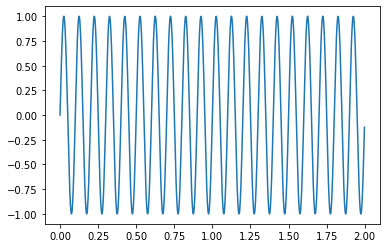

In [22]:
x0, t0 = generate_sinusoid(dur=2, Fs=512, amp=1, freq=10, phase=0)
x1, t1 = generate_sinusoid(dur=2, Fs=512, amp=0.2, freq=105, phase=(np.pi))

plt.plot(t0, x0)
plt.show()

### 2.2 Synthesizing sine tones using the exponential function

We know from lecture that we can also write down sinusoids using the exponential function, defined as $\exp(i \gamma) := \cos(\gamma) + i \sin(\gamma)$, where $i^2 = -1$.

How would you rewrite `generate_sinusoid` to use the exponential function to produce an identical result? You only need to change one line.

*Hint*: Compute the required signal using the polar form, and recover the coordinate corresponding to the relevant part using `.real` or `.imag`, as appropriate

In [ ]:
def generate_sinusoid_exp(dur, Fs, amp, freq, phase):
    """Generation of sinusoid using exponential function

    Args:
        dur (float): Duration (in seconds) 
        Fs (scalar): Sampling rate 
        amp (float): Amplitude of sinusoid
        freq (float): Frequency of sinusoid (in Hz)
        phase (float): Phase of sinusoid (in radians)

    Returns:
        x (np.ndarray): Signal
        t (np.ndarray): Time axis (in seconds)

    """
    # vvvvvvvvvvvvvvvvvvvvv
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = amp * np.exp(1j *(2*np.pi*(freq*t-phase))).imag
    return x, t
    # ^^^^^^^^^^^^^^^^^^^^^

We now have (at least) two options if we want to listen to sounds that these signals correspond to. The first option is to use a function from a library called `soundfile`, to save the NumPy array to disk, in some well-defined file format. 

Once we've done that we can go and fetch it from our environment (on NCC, return to the "Files" tab).

It is **essential** that you lower the volume before you listen to any files you generate using techniques like this. NumPy arrays do not care about your hearing.

In [24]:
x, t = generate_sinusoid(dur=2, Fs=8000, amp=0.1, freq=220, phase=0)
soundfile.write('out.wav',data=x, samplerate=8000)

Alternatively, we can listen to the sound (that we've just downloaded), without leaving the notebook, using a HTML5 component.

In [25]:
ipd.Audio('out.wav')

Even better, we can listen to the sound of any NumPy array without downloading and inline the player in the notebook, as follows:

In [26]:
ipd.Audio(t, rate=8000)

This is because the widget happily accepts NumPy arrays.

If we do not give the audio widget a sample rate, it will not know "how fast" (in real time) to traverse the array. If we give it an incorrect sample rate, it will not play back correctly. Try some different values for `rate`. 

What relationship holds between the sounds you hear, the sample rate with which the sinusoid is originally produced, and the sample rate that you tell the playback widget about?

Why do you think we did not need to tell the player widget the sample rate when we pointed it to the file on disk? Note that you can run shell commands from within notebooks using the `!` [cell magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html), formerly `%sc`)

In [27]:
!which file

/usr/bin/file


In [28]:
!file 'out.wav'

out.wav: RIFF (little-endian) data, WAVE audio, Microsoft PCM, 16 bit, mono 8000 Hz


### 2.3 Synthesizing a 12-tone equal tempered chromatic scale

Write a function `chromatic_scale` combining the implementations above to produce a sonification of the 12-tone equal tempered piano key steps (i.e. **semitones**) between `start_mnn` and `end_mnn` inclusive.

In [ ]:
def chromatic_scale(dur=2, start_mnn=69, end_mnn=81, Fs=8000):
    """Sonification of the steps of the chromatic scale 
          between two MIDI note numbers, inclusive.

    Args:
        dur (float): Total duration (in seconds) of the sonification
        start_mnn (int): Starting pitch (in MIDI note number)
        end_mnn (int): Ending pitch (in MIDI note number)
        Fs (scalar): Sampling rate 

    Returns:
        x (np.ndarray): Signal
        t (np.ndarray): Time axis (in seconds)

    """
    # vvvvvvvvvvvvvvvvvvvvv   
    x = []
    t = []
    
    for mnn in range(start_mnn, end_mnn + 1):
        xs, ts = generate_sinusoid(dur/(end_mnn - start_mnn + 1), Fs, 0.2, f_pitch(mnn), 0.1)
        x.append(xs)
        t.append(ts)
    
    return np.concatenate(x), np.concatenate(t)
    # ^^^^^^^^^^^^^^^^^^^^^

### 2.4 Synthesizing a random tune

In [ ]:
def random_tune(dur=2, num_tones=8, vocabulary=range(0,127), Fs=1200):
    """Produce a random tune.
    
    Args:
        dur (float): Total duration (in seconds) of the tune
        num_tones (int): Total number of tones in tune
        vocabulary (Iterable[int]): The permissible notes that may appear 
            in the tune (in MIDI note number)
        Fs (scalar): Sampling rate 

    Returns:
        x (np.ndarray): Signal
        t (np.ndarray): Time axis (in seconds)

    """
    # vvvvvvvvvvvvvvvvvvvvv
    import random
    
    x = []
    t = []
    
    for mnn in range(0, num_tones):
        mnn = random.choice(vocabulary)
        xs, ts = generate_sinusoid(dur/num_tones, Fs, 0.2, f_pitch(mnn), 0.1)
        x.append(xs)
        t.append(ts)
    
    return np.concatenate(x), np.concatenate(t)
    # ^^^^^^^^^^^^^^^^^^^^^

In [31]:
x1, t1 = random_tune(8, 32, [6, 32, 90], 22050)
x2, t2 = random_tune(8, 32, [78, 76, 74], 22050)

ipd.Audio((x1 + x2)/2, rate=22050)

These are the first steps towards automatic music composition systems. Play around with the parameters, and the probability distribution that you use to select notes from the vocabulary. What happens if you ask for several hundred notes per second? 

You can provide weights which influence the likelihood of the selection of a note using the `random.choices` function in the Python standard library. What would be required to make these sequences yet more musically interesting/plausible?

### 2.5 Synthesizing richer tones

In [32]:
def generate_rich(dur, Fs, specification):
    """Generate a rich tone out of simple sinusoids.

    Args:
        dur (float): Duration (in seconds) 
        Fs (scalar): Sampling rate 
        specification: (Iterable[Iterable[float, float, float]]): Specification 
          of the rich tone as a list of
          simultaneous components:
            amplitude (float): Amplitude of sinusoid
            freq (float): Frequency of sinusoid (in Hz)
            phase (float): Phase of sinusoid (in radians)

    Returns:
        x (np.ndarray): Signal
        t (np.ndarray): Time axis (in seconds)

    """
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = np.zeros(num_samples)
    for amp, freq, phase in specification:
        x_comp, t_comp = generate_sinusoid(dur=dur, Fs=Fs, amp=amp, freq=freq, phase=phase) 
        x += x_comp
    return x / np.max(x), t

In [33]:
NUM_COMPONENTS = 16

amplitudes = np.log2(np.linspace(2, 16, num=NUM_COMPONENTS))
amplitudes = amplitudes/np.max(amplitudes)

frequencies = (np.arange(1, 17)) * 440 + np.random.randint(-1, 1, size=NUM_COMPONENTS)

phases = np.zeros((NUM_COMPONENTS))

In [34]:
xr, tr = generate_rich(2, 8000, [spec for spec in zip(amplitudes, frequencies, phases)])

In [35]:
ipd.Audio(xr, rate=8000)

## 3 A (very) brief orientation in Librosa

`librosa` is a useful Python package (developed in the first instance as a port of MATLAB codes originally written by Daniel Ellis into Python, by his student Brian McFee) that we can use to read .wav files into a Python object, which brings with it useful features.

> McFee, Brian, Colin Raffel, Dawen Liang, Daniel PW Ellis, Matt McVicar, Eric Battenberg, and Oriol Nieto. “librosa: Audio and music signal analysis in Python.” In Proceedings of the 14th Python in Science Conference, pp. 18-25. 2015.

More than that, it is a comprehensive Python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

`librosa` users benefit from its [clear documentation](https://librosa.org/doc/latest/index.html). It used by researchers, educators, and engineers alike. It usefully provides citations to the original papers or conference presentations which describe many of the methods it implements. Some of these are by now well-established methods, and in production and state-of-the-art systems they may not be the first choice.

### 3.1 Loading an audio file 

Audio files are relatively straightforward, though there are a panoply of different digital formats available for storing audio. We focus on **lossless** formats in this submodule, specifically the `.wav` (Waveform Audio File Format/WAVE) format. 

Lossless, in this context, means no techinques have been applied to reduce the filesize of the audio representation other than a specific choice of **sampling** rate and **quantization** parameters (including bit-depth), which are a necessary part of sampling.

WAVE files come in a variety of flavours, but we will not be concerned with these differences. `librosa` interprets the relevant information in the file format to produce a tuple `(x, sr)`, where `x` is a NumPy array. What do you think `sr` is?

In [36]:
xs, Fs = librosa.load('out.wav')

### 3.2 Visualising an audio file

In [37]:
def show_waveform(x, Fs):
    """Sonify the steps of the chromatic scale between two
          MIDI note numbers, inclusive.

    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate 

    Returns:
        nothing
    """
    t = np.arange(len(x)) / Fs
    plt.figure()
    plt.plot(t, x)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

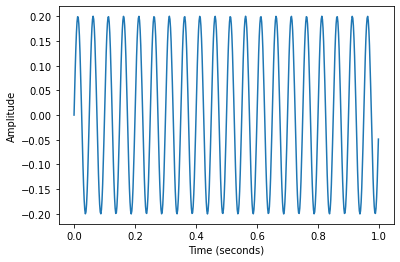

In [38]:
show_waveform(generate_sinusoid(1, 512, 0.2, 20, 2)[0], 512)

In [39]:
y, sr = librosa.load(librosa.util.example('trumpet'), duration=10)

In [40]:
ipd.Audio(y, rate=sr)

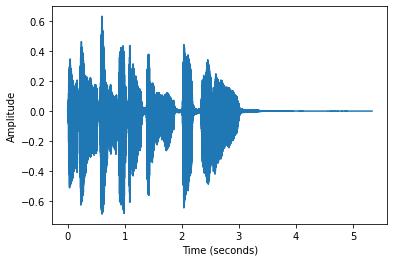

In [41]:
show_waveform(y, sr)

Conveniently enough, we do not need to write our own plotting code, as `librosa` provides some convenience functions to do so. For example, `librosa.display.waveshow` supports stereo signals (something we don't have time to cover). 

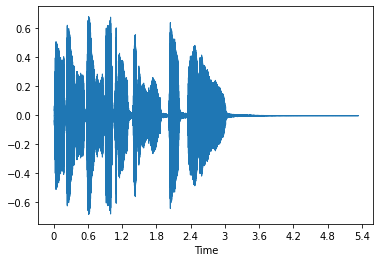

In [42]:
librosa.display.waveshow(y, sr=sr)

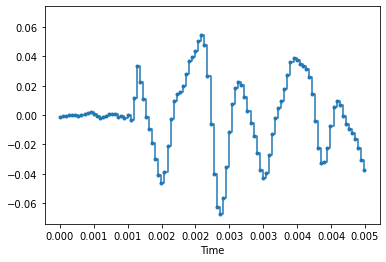

In [43]:
librosa.display.waveshow(y[:100], sr=sr, marker='.')

However, it (evidently) uses `matplotlib` under the hood and you can adapt or extend this as necessary, and use it, for example to build up a figure from multiple subplots, using the `ax=` parameter. 

### 3.3 Estimating fundamental frequency by peak finding

Let's have a closer look at the waveform plot of the trumpet recording. We know that for simple sounds we can measure the distance from peak to peak to compute the frequency of a signal that might generate it, and we can do something similar here.

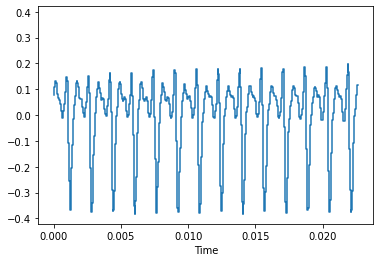

In [44]:
snippet = y[3000:3500]
librosa.display.waveshow(snippet, sr=sr)

We ultimately are trying to estimate the fundamental frequency of the note that we hear, which specifies the sinusoidal component that contributes most prominently to our sense of what the pitch of the sound is. This is only really viable for very straightforward sounds. The difficulty of this approach in settings where - for example - multiple instruments are playing at once is what motivates analysis in the frequency domain, using the Fourier transform.

We can use a `librosa` function called `pick_peak`, which implements a simple peak finding algorithm. You should invoke it with the following parameters: `librosa.util.peak_pick(x, pre_max=25, post_max=25, pre_avg=25, post_avg=25, delta=0.1, wait=10)`.

Write a function `estimate_frequency(x, Fs)` that uses peak picking to estimate the frequency of the most signficiant periodic component in the signal, returning this in Hertz (Hz).

In [ ]:
def estimate_frequency(x, Fs):
    """Provide a rough estimate of the frequency

    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate 

    Returns:
        f_estimate (float): Estimate of the signal based
          on computing distances between detected peaks.
    """
    # vvvvvvvvvvvvvvvvvvvvv
    peaks = librosa.util.peak_pick(x, pre_max=25, post_max=25, pre_avg=25, post_avg=25, delta=0.1, wait=10)
    average_delta = np.mean(np.diff(peaks))
    f_estimate = Fs / average_delta
    return f_estimate
    # ^^^^^^^^^^^^^^^^^^^^^

In [46]:
estimate_frequency(snippet, Fs=sr)

621.8004338394794

In [47]:
ipd.Audio(snippet, rate=sr)

In [48]:
x_est, t_est = generate_sinusoid(dur=2, Fs=16000, amp=1, freq=622.75, phase=0)
ipd.Audio(x_est, rate=16000)

### 3.4 Programmatic editing of sound files

At this point we are now used to the ideas that sample indexes into arrays give us access to audio data, that in order to reason about the phenomena that they represent. We also have been introduced to the idea that we can compute simple features (e.g. an estimate of the central frequency) over small chunks of audio data.

The last section will deal briefly with the use of the `librosa.remix` function, and then shows how detected beat locations can be used to segment audio files into smaller chunks. 

We examine how to compute very simple features for these segments. Finally, we reorder these segments and listen to the result. This can be a useful strategy for exploring a musical dataset or for stimulating creative sound editing. For example, we can compute some low level feature and sort the segments by this feature. Or, we can start to "mosaic" very short segments, from a variety of sound sources, together into a single recording: a kind of musical collage. 

First, we need a recording with a prominent beat. The **beat** is what we tap or clap along to; the beat is regular and is perceptible as such in a band of about 30-300 bpm.

But in this example there is much else other than musical articulations of the **beat**, such as the low kick drum, including other faster-moving drum rhythms and bass guitar notes that are higher in pitch and also greater in number of onsets.

In [49]:
drum_x, drum_Fs = librosa.load(librosa.example('choice'))
ipd.Audio(drum_x, rate=drum_Fs)

Next, we use `librosa.beat.beat_track`, a function which takes a signal and returns an estimate of the **tempo** of the track (essentially the frequency of the beat), and an array of locations where the estimated beat falls, expressed either in terms of samples or in terms of time. 

This is typical for some `librosa` implementations, which often provides the facility to convert between sample index and time, given the correct sampling rate. For more details, see [the documentation for this function](https://librosa.org/doc/0.10.1/generated/librosa.beat.beat_track.html#librosa.beat.beat_track).

In [50]:
tempo, beats_t = librosa.beat.beat_track(y=drum_x, sr=drum_Fs, units='time')

In [51]:
beats_t

array([ 0.06965986,  0.48761905,  0.92879819,  1.36997732,  1.81115646,
        2.22911565,  2.69351474,  3.13469388,  3.57587302,  4.01705215,
        4.45823129,  4.89941043,  5.34058957,  5.78176871,  6.22294785,
        6.66412698,  7.10530612,  7.54648526,  7.9876644 ,  8.42884354,
        8.87002268,  9.31120181,  9.75238095, 10.19356009, 10.63473923,
       11.05269841, 11.49387755, 11.95827664, 12.39945578, 12.84063492,
       13.28181406, 13.7229932 , 14.16417234, 14.60535147, 15.02331066,
       15.48770975, 15.92888889, 16.37006803, 16.81124717, 17.2524263 ,
       17.69360544, 18.11156463, 18.55274376, 19.01714286, 19.458322  ,
       19.89950113, 20.34068027, 20.78185941, 21.22303855, 21.66421769,
       22.08217687, 22.54657596, 22.9877551 , 23.40571429])

We can use `matplotlib` to visualise the temporal location of the detected events on top of the waveform plot. The below shows an idiomatic use of `librosa`'s plotting capabilities. Note that `ax.legend()` and the `label` parameter can be used to clearly state the source of the data being plotted, and that the axes are correctly and clearly labeled.

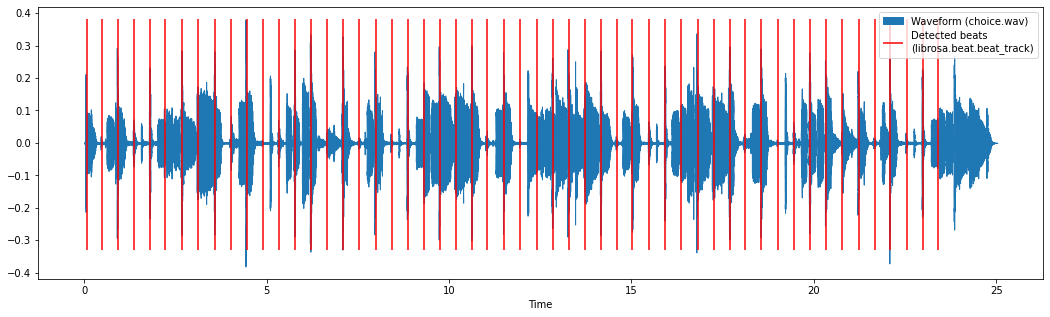

In [52]:
fig, ax = plt.subplots(figsize=(18,5))

librosa.display.waveshow(drum_x, ax=ax, label='Waveform (choice.wav)')

ax.vlines(beats_t, ymin=np.min(drum_x), ymax=np.max(drum_x), 
          color='red', label='Detected beats\n(librosa.beat.beat_track)')

ax.legend()

plt.show()

The last piece of the puzzle will involve manipulating the original audio to reorder chunks of samples ("frames") into the desired order. You could implement this yourself (please try this if you have time) or you can use the `librosa.effects.remix` facility, which consumes an audio array and list of time intervals (each interval a start and end time/index, as relevant) and returns the audio array which is remixed by re-ordering the source according to this list of time intervals.



Write a function `reverse_by_beat` which, given a musical track with a prominent beat, will return the track "reversed" by beat, with the individual beats in the original track appearing in reverse order. 

In [ ]:
def reverse_by_beat(x, Fs):
    """Reverse a music track by-beat, by doing beat detection,
         segmenting the original track into frames, and
         reordering the segments in reverse order.

    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate 

    Returns:
        f_estimate (np.ndarray): Remixed music signal.
    """
    # vvvvvvvvvvvvvvvvvvvvv
    tempo, beats_samples = librosa.beat.beat_track(y=x, sr=Fs, units='samples')
    intervals = librosa.util.frame(beats_samples, frame_length=2, hop_length=1).T
    remixed = librosa.effects.remix(drum_x, intervals[::-1])
    return remixed
    # ^^^^^^^^^^^^^^^^^^^^^

In [54]:
ipd.Audio(reverse_by_beat(drum_x, drum_Fs), rate=drum_Fs)

And just so we are perfectly clear, this is what the same excerpt sounds like when reversed on a samplewise basis (i.e. reading the audio file from back to front).

In [55]:
ipd.Audio(drum_x[::-1], rate=drum_Fs)

Now think about other ways to provide an ordering on the intervals that could be used in a programmatic remix? Or other ways/criteria that can be used to identify segmentations of a signal? Have a look, for example, at `librosa.onset.onset_detect`, which will trigger much more frequently (and irregularly) than the beat detector.

Can you try to use your implementation of `estimate_frequency` to try and "sort" these segments by pitch? Next week, we will define more complex features to describe the pitch and harmonic content of musical sounds (drawing on spectrogram representations). If you are interested in learning more, a look at the contents of `librosa.feature`.

Recall the MusicMappr application I presented in the first lecture (https://fatsmcgee.github.io/MusicMappr/). You can combine feature extraction and clustering (e.g. using `sklearn` or your own ideas) to determine the sequence in which segments are played. Or, you could use some other technique to minimise/maximise some cost function, which in turn depends on the structure of the audio. Have a look at this re-implementation of [The Eternal Jukebox
](https://www.eternalboxmirror.xyz/jukebox_search.html) by Paul Lamere, which he wrote up in 2012 (https://musicmachinery.com/2012/11/12/the-infinite-jukebox/).

In [56]:
dir(librosa.feature)

['chroma_cens',
 'chroma_cqt',
 'chroma_stft',
 'chroma_vqt',
 'delta',
 'fourier_tempogram',
 'inverse',
 'melspectrogram',
 'mfcc',
 'poly_features',
 'rms',
 'spectral_bandwidth',
 'spectral_centroid',
 'spectral_contrast',
 'spectral_flatness',
 'spectral_rolloff',
 'stack_memory',
 'tempo',
 'tempogram',
 'tempogram_ratio',
 'tonnetz',
 'zero_crossing_rate']